# Solving Navier-Stokes 2D for a lid-driven cavity numerically

## Appendix : a quick reminder

In [ ]:
"""
N-S equation : ∂u/∂t + (u ⋅ ∇) u = − 1/ρ ∇p + ν ∇²u + f
Incompressibility:  ∇ ⋅ u = 0
We'll save the velocity vx and vy on a N*N grid, as well as the pressure p

We will solve using the Chorin's Splitting :
1. Solve momentum without any pressure gradient
2. Solve pressure poisson equation

Ref for the numerical solving part : https://github.com/Ceyron/machine-learning-and-simulation/blob/main/english/simulation_scripts/lid_driven_cavity_python_simple.py
"""

"\nN-S equation : ∂u/∂t + (u ⋅ ∇) u = − 1/ρ ∇p + ν ∇²u + f\nIncompressibility:  ∇ ⋅ u = 0\n\nWe'll save the velocity vx and vy on a N*N grid, as well as the pressure p\n\nWe will solve using the Chorin's Splitting :\n1. Solve momentum without any pressure gradient\n2. Solve pressure poisson equation\n\nRef for the numerical solving part : https://github.com/Ceyron/machine-learning-and-simulation/blob/main/english/simulation_scripts/lid_driven_cavity_python_simple.py\n"

## I - Imports 

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd

## II - Setup of the experiment

### II - a  - Parameters of the Experiment


In [4]:
Nx = Ny = 51  # grid points
Lx = Ly = 1.0        # domain size
dx = Lx / (Nx - 1)
dy = Ly / (Ny - 1)
dt = 0.001           # time step
nt = 2000            # number of time steps
kinematic_viscosity = 0.1
density = 1
lid_velocity = 1.0
stability_factor = 0.5
n_pressure_iter = 50


### II - b - Check the Validity of the Parameters

In [5]:
maximum_possible_time_step_length = (0.5 * dx**2 / kinematic_viscosity)

if dt > stability_factor * maximum_possible_time_step_length:
    print("Stability is not guarenteed")


### II - c - Initializing the Fields

In [6]:
x = np.linspace(0.0, Lx, Nx)
y = np.linspace(0.0, Ly, Ny)
x_grid, y_grid = np.meshgrid(x, y)

u_field = np.zeros((Ny, Nx))   # x-velocity
v_field = np.zeros((Ny, Nx))   # y-velocity
p_field = np.zeros((Ny, Nx))   # pressure

### II - d - Boundary Conditions

In [7]:
def apply_velocities_bc(u_field, v_field):
        u_field[0, :] = 0.0
        u_field[:, 0] = 0.0
        u_field[:, -1] = 0.0
        u_field[-1, :] = lid_velocity
        v_field[0, :] = 0.0
        v_field[:, 0] = 0.0
        v_field[:, -1] = 0.0
        v_field[-1, :] = 0.0

def apply_pressure_bc(p_field):
        p_field[:, -1] = p_field[:, -2]
        p_field[0,  :] = p_field[1,  :]
        p_field[:,  0] = p_field[:,  1]
        p_field[-1, :] = 0.0

## III - Solving without the Pressure Gradient

### III - a - A few functions that might help us

In [8]:
def central_difference_x(f):
    diff = np.zeros_like(f)
    diff[1:-1, 1:-1] = (
        f[1:-1, 2:] - f[1:-1, 0:-2]) / (2 * dx) 
    return diff

def central_difference_y(f):
    diff = np.zeros_like(f)
    diff[1:-1, 1:-1] = (
        f[2:, 1:-1] - f[0:-2, 1:-1]) / (2 * dy)
    return diff


def laplace(f):
    diff = np.zeros_like(f)
    diff[1:-1, 1:-1] = (f[1:-1, 0:-2] + f[0:-2, 1:-1] - 4 * f[1:-1, 1:-1] + f[1:-1, 2: ] + f[2:, 1:-1]) / (dx**2)
    return diff

### III - b - Define the Pressure Poisson Solver Function 

In [9]:
def pressure_solver(du_tent_dx, dv_tent_dy, p_field):
    rhs = (density / dt * (du_tent_dx + dv_tent_dy))

    for _ in range(n_pressure_iter):
        p_next = np.zeros_like(p_field)
        p_next[1:-1, 1:-1] = 1/4 * (p_field[1:-1, 0:-2] + p_field[0:-2, 1:-1] + p_field[1:-1, 2: ] + p_field[2: , 1:-1] - dx**2 * rhs[1:-1, 1:-1])

        apply_pressure_bc(p_next)

        p_field = p_next
    
    dp_next_dx = central_difference_x(p_next)
    dp_next_dy = central_difference_y(p_next)

    return dp_next_dx, dp_next_dy, p_next


### III - c - Define the Momentum Function without Pressure Gradient

In [1]:
def momentum_without_pressure_gradient(u_field, v_field, p_field):

    u_history = np.zeros((nt, Ny, Nx))
    v_history = np.zeros((nt, Ny, Nx))
    p_history = np.zeros((nt, Ny, Nx))
    apply_velocities_bc(u_field, v_field)
    apply_pressure_bc(p_field)
    

    for t_step in tqdm(range(nt)):
        du_prev_dx = central_difference_x(u_field)
        dv_prev_dy = central_difference_y(v_field)
        dv_prev_dx = central_difference_x(v_field)
        du_prev_dy = central_difference_y(u_field)

        laplace_u_prev = laplace(u_field)
        laplace_v_prev = laplace(v_field)

        u_tent = (u_field + dt * (- (u_field * du_prev_dx + v_field * du_prev_dy) + kinematic_viscosity * laplace_u_prev))
        v_tent = (v_field + dt * (- (u_field * dv_prev_dx + v_field * dv_prev_dy) + kinematic_viscosity * laplace_v_prev))

        apply_velocities_bc(u_tent, v_tent)

        du_tent_dx = central_difference_x(u_tent)
        dv_tent_dy = central_difference_y(v_tent)

        dp_next_dx, dp_next_dy, p_next = pressure_solver(du_tent_dx, dv_tent_dy, p_field)

        u_next = (u_tent - dt / density * dp_next_dx)
        v_next = (v_tent - dt / density * dp_next_dy)

        apply_velocities_bc(u_next, v_next)

        u_field = u_next
        v_field = v_next
        p_field = p_next

        

        u_history[t_step] = u_field
        v_history[t_step] = v_field
        p_history[t_step] = p_field
        


    np.savez(r'.\data\cavity_flow_history.npz', u=u_history, v=v_history, p=p_history, x=x, y=y)
    print("Saved velocity and pressure history to 'cavity_flow_history.npz'") 
    
    return p_field, u_field, v_field   

 


## IV - Plotting the Results

100%|██████████| 2000/2000 [00:05<00:00, 381.68it/s]


Saved velocity and pressure history to 'cavity_flow_history.npz'


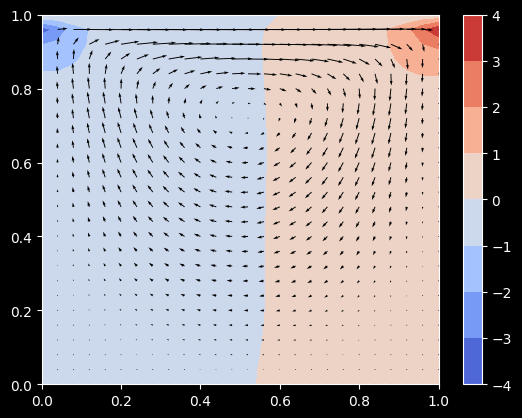

In [10]:
p_field, u_field, v_field = momentum_without_pressure_gradient(u_field, v_field, p_field)

plt.style.use("dark_background")
plt.figure()
plt.contourf(x_grid[::2, ::2], y_grid[::2, ::2], p_field[::2, ::2], cmap="coolwarm")
plt.colorbar()
# plt.streamplot(x_grid[::2, ::2], y_grid[::2, ::2], u_field[::2, ::2], v_field[::2, ::2], color="black")
plt.quiver(x_grid[::2, ::2], y_grid[::2, ::2], u_field[::2, ::2], v_field[::2, ::2], color="black")
plt.xlim((0, 1))
plt.ylim((0, 1))
plt.show()

# Beginning of the NN

## I - Imports


In [17]:
import torch 
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import torchvision

## II - Preprocessing the Data

### II - a - Load the Data and fitting numpy

In [18]:
data = np.load(r'.\data\cavity_flow_history.npz')
print(data.files)

u_hist = data['u']  # shape (nt, Ny, Nx)
v_hist = data['v']  # shape (nt, Ny, Nx)
p_hist = data['p']  # shape (nt, Ny, Nx)
x = data['x']  # shape (Nx,)
y = data['y']  # shape (Ny,)

seq_len = 24
X = []
Y = []

for t in range(u_hist.shape[0] - seq_len):
    seq_u = u_hist[t:t+seq_len]
    seq_v = u_hist[t:t+seq_len]
    seq_p = u_hist[t:t+seq_len]

    seq = np.stack([seq_u, seq_v, seq_p], axis=-1)

    target = np.stack([u_hist[t+seq_len], v_hist[t+seq_len], p_hist[t+seq_len]], axis=-1)

    X.append(seq)
    Y.append(target)

X = np.array(X)
Y = np.array(Y)

print(X.shape)




['u', 'v', 'p', 'x', 'y']
(1976, 24, 51, 51, 3)


### II - b - Using DataLoader

In [29]:
X_tensor = torch.tensor(X, dtype=torch.float32)
Y_tensor = torch.tensor(Y, dtype=torch.float32)

X_tensor = X_tensor.permute(0, 1, 4, 2, 3)
Y_tensor = Y_tensor.permute(0, 3, 1, 2)

print(X_tensor.shape)
print(Y_tensor.shape)

dataset = TensorDataset(X_tensor, Y_tensor)
trainloader = DataLoader(dataset, batch_size=8, shuffle=True)

torch.Size([1976, 24, 3, 51, 51])
torch.Size([1976, 3, 51, 51])


## III - Creating the Neural Network 

In [30]:
class ConvLSTMCell(nn.Module):
    def __init__(self, input_channels, hidden_channels, kernel_size):
        super().__init__()
        padding = kernel_size // 2
        self.input_channels = input_channels
        self.hidden_channels = hidden_channels

        self.conv = nn.Conv2d(input_channels + hidden_channels, 4 * hidden_channels, kernel_size, padding=padding)

    def forward(self, x, h_cur, c_cur):
        combined = torch.cat([x, h_cur], dim=1)  # concat along channels
        conv_out = self.conv(combined)
        (cc_i, cc_f, cc_o, cc_g) = torch.split(conv_out, self.hidden_channels, dim=1)
        i = torch.sigmoid(cc_i)
        f = torch.sigmoid(cc_f)
        o = torch.sigmoid(cc_o)
        g = torch.tanh(cc_g)
        
        c_next = f * c_cur + i * g
        h_next = o * torch.tanh(c_next)
        return h_next, c_next
        

class SimpleConvLSTM(nn.Module):
    def __init__(self, input_channels=3, hidden_channels=32, kernel_size=3):
        super().__init__()
        self.hidden_channels = hidden_channels
        self.cell = ConvLSTMCell(input_channels, hidden_channels, kernel_size)
        self.conv_out = nn.Conv2d(hidden_channels, input_channels, kernel_size=1)  # output u,v,p

    def forward(self, x):
        """
        x: (batch, seq_len, channels, Ny, Nx)
        returns: next frame (batch, channels, Ny, Nx)
        """
        batch_size, seq_len, channels, Ny, Nx = x.shape
        h = torch.zeros(batch_size, self.hidden_channels, Ny, Nx, device=x.device)
        c = torch.zeros(batch_size, self.hidden_channels, Ny, Nx, device=x.device)

        for t in range(seq_len):
            h, c = self.cell(x[:, t], h, c)
        
        out = self.conv_out(h)
        return out


device = "cuda" if torch.cuda.is_available() else "cpu"
model = SimpleConvLSTM().to(device)

criterion = nn.MSELoss()  # predicting continuous fields
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)


n_epochs = 2

for epoch in range(n_epochs):
    running_loss = 0.0
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs = inputs.to(device)
        targets = targets.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    
    print(f"Epoch {epoch+1}/{n_epochs}, Loss: {running_loss/len(trainloader):.6f}")


Epoch 1/2, Loss: 0.018019
Epoch 2/2, Loss: 0.000919


## IV - Checking the Results

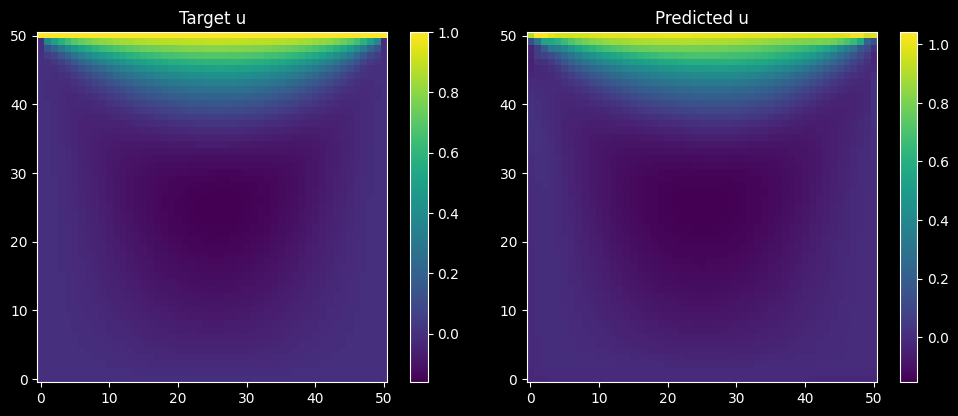

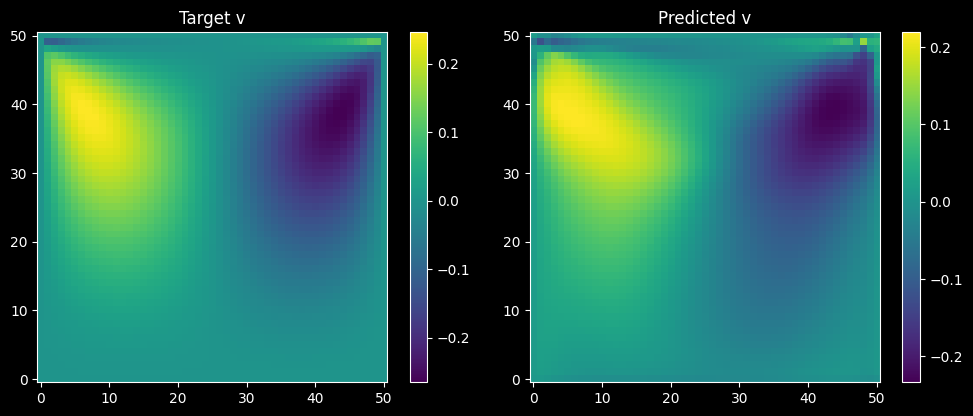

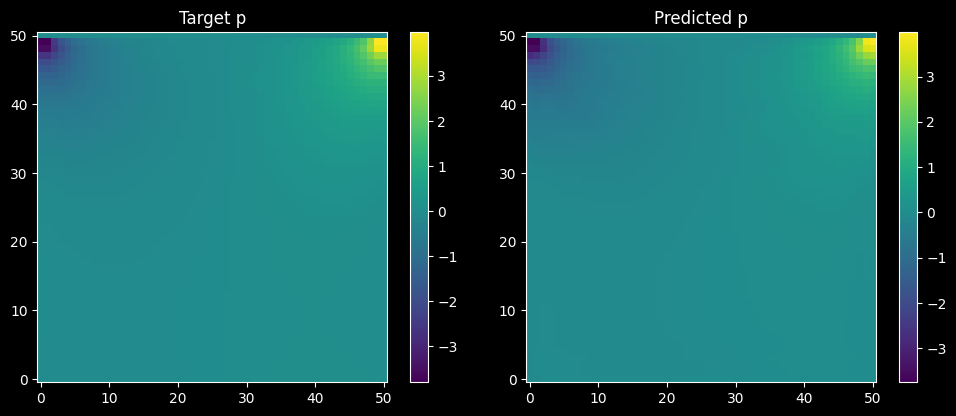

In [31]:

# Pick a batch from your trainloader (or any specific index)
inputs, targets = next(iter(trainloader))
inputs = inputs.to(device)
targets = targets.to(device)

# Make prediction
model.eval()
with torch.no_grad():
    pred = model(inputs)

# Move to CPU and numpy for plotting
inputs = inputs.cpu().numpy()
targets = targets.cpu().numpy()
pred = pred.cpu().numpy()

# Pick the first sample in the batch
sample_idx = 0
channels = ['u', 'v', 'p']

for c_idx, c_name in enumerate(channels):
    plt.figure(figsize=(10,4))
    
    plt.subplot(1,2,1)
    plt.imshow(targets[sample_idx, c_idx], origin='lower', cmap='viridis')
    plt.colorbar()
    plt.title(f"Target {c_name}")
    
    plt.subplot(1,2,2)
    plt.imshow(pred[sample_idx, c_idx], origin='lower', cmap='viridis')
    plt.colorbar()
    plt.title(f"Predicted {c_name}")
    
    plt.tight_layout()
    plt.show()



# Going Further, Adding a Scalar Parameter (need to be changed)

## I - Slightly Changing the Original Code to Store Multiple Datasets

In [32]:
def simulate_cavity_flow(kinematic_viscosity, save_path):
    u_field = np.zeros((Ny, Nx))
    v_field = np.zeros((Ny, Nx))
    p_field = np.zeros((Ny, Nx))

    apply_velocities_bc(u_field, v_field)
    apply_pressure_bc(p_field)

    u_history = np.zeros((nt, Ny, Nx))
    v_history = np.zeros((nt, Ny, Nx))
    p_history = np.zeros((nt, Ny, Nx))

    for t_step in tqdm(range(nt)):
        du_prev_dx = central_difference_x(u_field)
        dv_prev_dy = central_difference_y(v_field)
        dv_prev_dx = central_difference_x(v_field)
        du_prev_dy = central_difference_y(u_field)

        laplace_u_prev = laplace(u_field)
        laplace_v_prev = laplace(v_field)

        # Tentative velocities (no pressure gradient)
        u_tent = u_field + dt * (-(u_field * du_prev_dx + v_field * du_prev_dy)
                                 + kinematic_viscosity * laplace_u_prev)
        v_tent = v_field + dt * (-(u_field * dv_prev_dx + v_field * dv_prev_dy)
                                 + kinematic_viscosity * laplace_v_prev)

        apply_velocities_bc(u_tent, v_tent)

        du_tent_dx = central_difference_x(u_tent)
        dv_tent_dy = central_difference_y(v_tent)

        dp_next_dx, dp_next_dy, p_next = pressure_solver(du_tent_dx, dv_tent_dy, p_field)

        u_next = u_tent - dt / density * dp_next_dx
        v_next = v_tent - dt / density * dp_next_dy

        apply_velocities_bc(u_next, v_next)

        u_field = u_next
        v_field = v_next
        p_field = p_next

        u_history[t_step] = u_field
        v_history[t_step] = v_field
        p_history[t_step] = p_field

    np.savez(save_path,
             u=u_history,
             v=v_history,
             p=p_history,
             viscosity=kinematic_viscosity,
             x=x, y=y)

    print(f"Saved dataset at viscosity={kinematic_viscosity} → {save_path}")

    return u_history, v_history, p_history

## II - Generating the Datasets Depending on Viscosity

In [33]:
viscosities = [0.001, 0.003, 0.005, 0.008, 0.01]
for nu in viscosities:
    save_path = f"./data/cavity_nu_{nu}.npz"
    simulate_cavity_flow(kinematic_viscosity=nu, save_path=save_path)



100%|██████████| 2000/2000 [00:05<00:00, 345.57it/s]


Saved dataset at viscosity=0.001 → ./data/cavity_nu_0.001.npz


100%|██████████| 2000/2000 [00:12<00:00, 160.11it/s]


Saved dataset at viscosity=0.003 → ./data/cavity_nu_0.003.npz


100%|██████████| 2000/2000 [00:15<00:00, 129.35it/s]


Saved dataset at viscosity=0.005 → ./data/cavity_nu_0.005.npz


100%|██████████| 2000/2000 [00:16<00:00, 123.88it/s]


Saved dataset at viscosity=0.008 → ./data/cavity_nu_0.008.npz


100%|██████████| 2000/2000 [00:14<00:00, 134.79it/s]


Saved dataset at viscosity=0.01 → ./data/cavity_nu_0.01.npz


In [34]:
data_1 = np.load(r'.\data\cavity_nu_0.01.npz')
print(data_1.files)

['u', 'v', 'p', 'viscosity', 'x', 'y']


## III - Parametric Data Loader

In [ ]:
class ParametricDataset(torch.utils.data.Dataset):
    def __init__(self, file_list):
        self.file_list = file_list
    
    def __getitem__(self, idx):
        data = np.load(self.file_list[idx])
        u = data["u"]
        v = data["v"]
        p = data["p"]
        viscosity = data["viscosity"]

        T, Ny, Nx = u.shape

        viscosity_map = np.full((T, Ny, Nx), viscosity)

        x = np.stack([u[:-1], v[:-1], p[:-1], viscosity_map[:-1]], axis=1)
        y = np.stack([u[1:], v[1:], p[1:]], axis=1)

        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)
    
    def __len__(self):
        return len(self.file_list)

## IV - Preprocess the Data Files

In [ ]:
file_list = [
    "./data/cavity_nu_0.008.npz",
    "./data/cavity_nu_0.003.npz",
    "./data/cavity_nu_0.001.npz",
    "./data/cavity_nu_0.005.npz",
    "./data/cavity_nu_0.01.npz",
]

# dataset
dataset = ParametricDataset(file_list)
trainloader = DataLoader(dataset, batch_size=2, shuffle=True)


## V - Create a New Neural Network (Parametric)

In [43]:
class ParametricLSTM(nn.Module):
    def __init__(self, input_channels=4, hidden_channels=32, kernel_size=1):
        super().__init__()
        self.hidden_channels = hidden_channels
        self.cell = ConvLSTMCell(input_channels, hidden_channels, kernel_size)
        self.conv_out = nn.Conv2d(hidden_channels, 3, kernel_size=1)
    
    def forward(self, x):
        B, T, C, Ny, Nx = x.shape
        h = torch.zeros(B, self.hidden_channels, Ny, Nx, device=x.device)
        c = torch.zeros(B, self.hidden_channels, Ny, Nx, device=x.device)

        for t in range(T):
            h, c = self.cell(x[:, t], h, c)
        
        return self.conv_out(h)


## VI - Training the Network

In [45]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = ParametricLSTM().to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

n_epochs = 3

for epoch in range(n_epochs):
    total_loss = 0.0
    for x,y in trainloader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        B, T, C, Ny, Nx = x.shape
        outputs = model(x)
        target = y[:, -1]
        loss = criterion(outputs, target)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(total_loss)
    print(f"Epoch {epoch+1} done.")

        

0.10684262588620186
Epoch 1 done.
0.096829853951931
Epoch 2 done.
0.08684626780450344
Epoch 3 done.


## VII - Checking the Results

100%|██████████| 2000/2000 [00:05<00:00, 358.92it/s]


Saved dataset at viscosity=0.002 → ./data/cavity_nu_0.002.npz


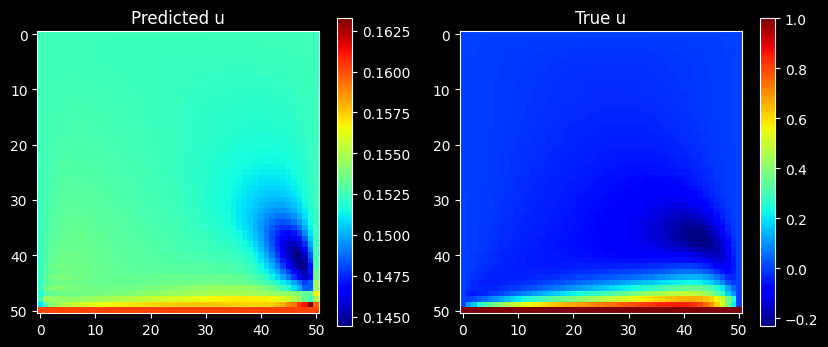

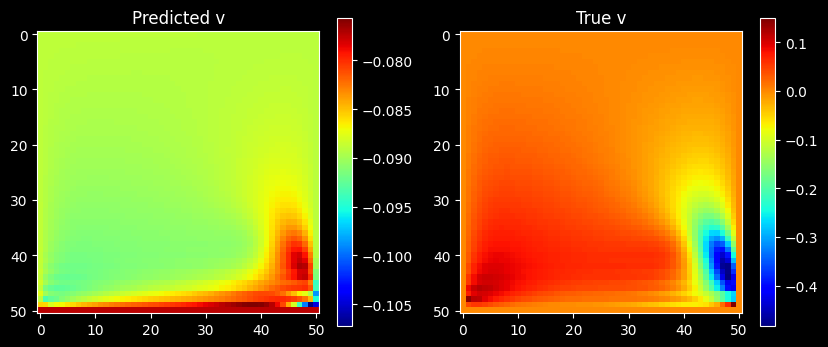

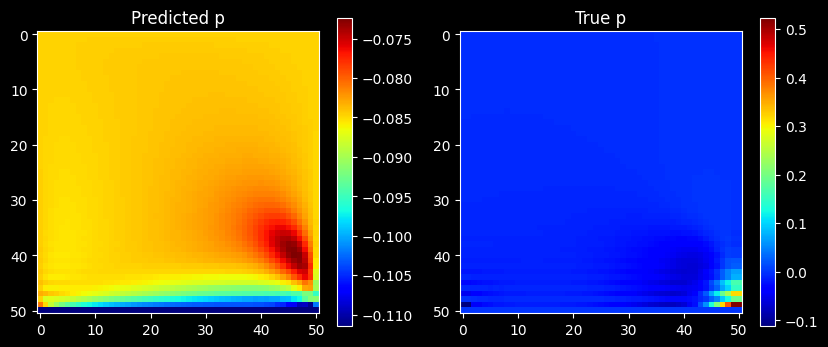

In [47]:
new_viscosity = 0.002
save_path_new = f"./data/cavity_nu_{new_viscosity}.npz"
u_hist, v_hist, p_hist = simulate_cavity_flow(new_viscosity, save_path_new)

test_dataset = ParametricDataset(["./data/cavity_nu_0.002.npz"])
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

model.eval()
with torch.no_grad():
    for x, y in test_loader:
        x = x.to(device)
        y = y.to(device)

        # one-step prediction
        pred_next = model(x)       # shape: (1, 3, Ny, Nx)
        true_next = y[:, -1]       # shape: (1, 3, Ny, Nx)


pred_u = pred_next[0,0].cpu().numpy()
pred_v = pred_next[0,1].cpu().numpy()
pred_p = pred_next[0,2].cpu().numpy()

true_u = true_next[0,0].cpu().numpy()
true_v = true_next[0,1].cpu().numpy()
true_p = true_next[0,2].cpu().numpy()

fields = ["u", "v", "p"]

for i, (pred, true, name) in enumerate([
    (pred_u, true_u, "u"),
    (pred_v, true_v, "v"),
    (pred_p, true_p, "p")
]):
    plt.figure(figsize=(10,4))
    
    plt.subplot(1,2,1)
    plt.title(f"Predicted {name}")
    plt.imshow(pred, cmap="jet")
    plt.colorbar()

    plt.subplot(1,2,2)
    plt.title(f"True {name}")
    plt.imshow(true, cmap="jet")
    plt.colorbar()

    plt.show()